**Praktikum 1**

**RNN untuk Analisis Sentimen**

In [1]:
# Import library
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

tfds.disable_progress_bar()

In [2]:
# Fungsi pembantu untuk memplot grafik:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [3]:
# Setup input pipeline

# Mengunduh dataset 'imdb_reviews' dari TensorFlow Datasets (tfds)
# 'with_info=True' digunakan untuk memuat informasi tambahan tentang dataset
# 'as_supervised=True' digunakan untuk memuat dataset dalam bentuk pasangan (data, label)
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

# Memisahkan dataset menjadi dataset pelatihan dan dataset pengujian
train_dataset, test_dataset = dataset['train'], dataset['test']

# Menampilkan struktur elemen dari dataset pelatihan
train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
# Mengambil satu contoh dari dataset pelatihan menggunakan 'train_dataset.take(1)'
# Ini akan menghasilkan satu pasangan (data, label)
for example, label in train_dataset.take(1):
  # Mencetak teks ulasan dari contoh sebagai nilai dalam bentuk numpy array
  print('text: ', example.numpy())
  # Mencetak label dari contoh sebagai nilai dalam bentuk numpy array
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
# Menentukan ukuran buffer untuk shuffle
BUFFER_SIZE = 10000

# Menentukan ukuran batch
BATCH_SIZE = 64

# Mengacak ulang (shuffle) dataset pelatihan dengan buffer sebesar BUFFER_SIZE
# dan membaginya menjadi batch dengan ukuran BATCH_SIZE
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Memisahkan dataset pengujian menjadi batch dengan ukuran BATCH_SIZE
# dan menggunakan prefetching untuk mempercepat pembacaan data
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Mengambil satu batch (dalam hal ini, pertama) dari dataset pelatihan
for example, label in train_dataset.take(1):
  # Mencetak tiga teks ulasan pertama dalam batch
  print('texts: ', example.numpy()[:3])
  print()
  # Mencetak tiga label pertama dalam batch
  print('labels: ', label.numpy()[:3])

texts:  [b"Orca starts as crusty Irish sea captain Nolan (Richard Harris) & his crew are trying to capture a Great White Shark so they can sell it for big bucks, unfortunately when a hapless marine biologist called Ken (Robert Carradine) comes under attack from it the Shark is killed by a Killer Whale, this raises Nolan's interest in Killer Whales & decides he want's to catch one of them instead. However while trying to do so he catches a pregnant female & injuries it to the extent she aborts her unborn foetus on deck which makes a mess & enrages her mate, Nolan orders the Whale be dumped back in the sea which is what happens. The male Killer Whale is annoyed to say the least & kills one of Nolan's crew before they reach the dry land of Newfoundland in Canada, once there the Killer Whale conducts a series of attacks on the town & it's people in an effort to lure Nolan back out to sea for a fight to the death...<br /><br />Directed by Michael Anderson I thought this blatant rip-off was 

In [6]:
# Menentukan ukuran vokabuler (VOCAB_SIZE)
VOCAB_SIZE = 1000

# Membuat sebuah objek TextVectorization (encoder) dengan batasan jumlah token maksimal (max_tokens) sebesar VOCAB_SIZE
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)

# Menyesuaikan encoder dengan dataset pelatihan
# Menggunakan metode 'adapt' untuk mengambil teks dari dataset pelatihan
# 'train_dataset.map(lambda text, label: text)' digunakan untuk mengambil hanya teks (tanpa label) dari setiap contoh dataset pelatihan
encoder.adapt(train_dataset.map(lambda text, label: text))

In [7]:
# Mengambil vokabuler dari encoder
vocab = np.array(encoder.get_vocabulary())

# Mencetak 20 token pertama dalam vokabuler
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [8]:
# Menggunakan encoder untuk mengonversi tiga contoh teks pertama dalam dataset pelatihan
encoded_example = encoder(example)[:3].numpy()

# Mencetak hasil representasi numerik dari teks
encoded_example

array([[  1, 500,  15, ...,   0,   0,   0],
       [209,  21, 599, ...,   0,   0,   0],
       [ 13,  13, 401, ...,   0,   0,   0]])

In [9]:
# Loop untuk melakukan round-trip pada tiga contoh
for n in range(3):
  # Mencetak teks asli
  print("Original: ", example[n].numpy())

  # Menggunakan vokabuler (vocab) untuk mengubah representasi numerik (encoded_example) kembali menjadi teks
  # " ".join()" digunakan untuk menggabungkan token-token dalam satu kalimat
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))

  # Mencetak baris kosong untuk pemisah
  print()

Original:  b"Orca starts as crusty Irish sea captain Nolan (Richard Harris) & his crew are trying to capture a Great White Shark so they can sell it for big bucks, unfortunately when a hapless marine biologist called Ken (Robert Carradine) comes under attack from it the Shark is killed by a Killer Whale, this raises Nolan's interest in Killer Whales & decides he want's to catch one of them instead. However while trying to do so he catches a pregnant female & injuries it to the extent she aborts her unborn foetus on deck which makes a mess & enrages her mate, Nolan orders the Whale be dumped back in the sea which is what happens. The male Killer Whale is annoyed to say the least & kills one of Nolan's crew before they reach the dry land of Newfoundland in Canada, once there the Killer Whale conducts a series of attacks on the town & it's people in an effort to lure Nolan back out to sea for a fight to the death...<br /><br />Directed by Michael Anderson I thought this blatant rip-off wa

In [10]:
# Membuat sebuah model sequential
model = tf.keras.Sequential([
    # Encoder (TextVectorization) untuk mengonversi teks ke representasi numerik
    encoder,

    # Layer embedding dengan input_dim sesuai dengan ukuran vokabuler
    # dan output_dim sebesar 64
    # 'mask_zero=True' digunakan untuk mengatasi panjang urutan teks yang bervariasi
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),

    # Layer Bidirectional LSTM dengan 64 unit
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),

    # Layer Dense dengan 64 unit dan aktivasi ReLU
    tf.keras.layers.Dense(64, activation='relu'),

    # Layer Dense dengan 1 unit (kemungkinan output biner)
    tf.keras.layers.Dense(1)
])

In [11]:
# Menggunakan list comprehension untuk membuat daftar yang berisi informasi apakah setiap lapisan mendukung masking
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [12]:
# Teks sampel yang akan diprediksi
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Melakukan prediksi pada teks sampel
# Menggunakan model.predict() dengan teks sampel yang diubah menjadi NumPy array
predictions = model.predict(np.array([sample_text]))

# Mencetak hasil prediksi
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[0.01462825]


In [13]:
# Memprediksi contoh teks dengan padding
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 85ms/step
[0.01462825]


In [14]:
# Mengompilasi model dengan konfigurasi tertentu
model.compile(
    # Fungsi kerugian (loss function)
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),

    # Optimizer (algoritma pelatihan), menggunakan Adam dengan laju pembelajaran 1e-4
    optimizer=tf.keras.optimizers.Adam(1e-4),

    # Metrik evaluasi yang akan digunakan selama pelatihan, dalam hal ini, akurasi (accuracy)
    metrics=['accuracy']
)

In [15]:
# Melatih model dengan data pelatihan selama 10 epoch
# Menggunakan model.fit() untuk melatih model
# 'train_dataset' adalah dataset pelatihan
# 'validation_data' adalah dataset validasi
# 'validation_steps' adalah jumlah langkah validasi yang akan dieksekusi
history = model.fit(
    train_dataset,  # Dataset pelatihan
    epochs=10,  # Jumlah epoch
    validation_data=test_dataset,  # Dataset validasi
    validation_steps=30  # Jumlah langkah validasi
)

Epoch 1/10
391/391 [==============================] - 47s 97ms/step - loss: 0.6638 - accuracy: 0.5454 - val_loss: 0.5150 - val_accuracy: 0.7625
Epoch 2/10
391/391 [==============================] - 26s 65ms/step - loss: 0.4344 - accuracy: 0.8022 - val_loss: 0.3930 - val_accuracy: 0.8349
Epoch 3/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3512 - accuracy: 0.8454 - val_loss: 0.3552 - val_accuracy: 0.8302
Epoch 4/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3282 - accuracy: 0.8556 - val_loss: 0.3394 - val_accuracy: 0.8542
Epoch 5/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3159 - accuracy: 0.8644 - val_loss: 0.3294 - val_accuracy: 0.8521
Epoch 6/10
391/391 [==============================] - 23s 59ms/step - loss: 0.3059 - accuracy: 0.8691 - val_loss: 0.3259 - val_accuracy: 0.8542
Epoch 7/10
391/391 [==============================] - 24s 60ms/step - loss: 0.3046 - accuracy: 0.8695 - val_loss: 0.3382 - val_accuracy:

In [16]:
# Menggunakan model.evaluate() untuk mengevaluasi model menggunakan dataset pengujian
test_loss, test_acc = model.evaluate(test_dataset)

# Mencetak hasil loss dan akurasi pengujian
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 11s 28ms/step - loss: 0.3143 - accuracy: 0.8604
Test Loss: 0.3143351674079895
Test Accuracy: 0.8603600263595581


(0.0, 0.6822401419281959)

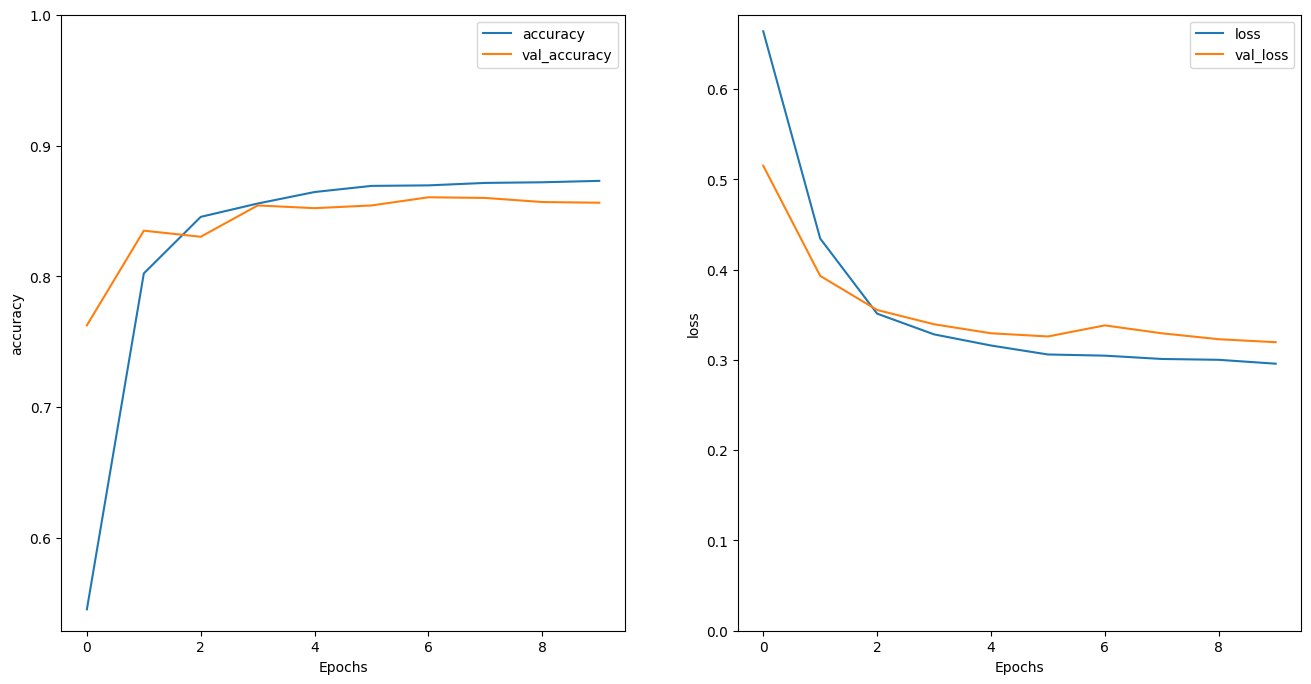

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [18]:
sample_text = ('The movie was cool. The animation and the graphics '
                'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[0.56950897]


In [19]:
# Membuat model dengan arsitektur yang berbeda
model = tf.keras.Sequential([
    # Encoder (TextVectorization) untuk mengonversi teks ke representasi numerik
    encoder,

    # Layer embedding dengan input_dim sesuai dengan ukuran vokabuler
    # dan output_dim sebesar 64, dengan masking
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),

    # Layer Bidirectional LSTM dengan 64 unit dan return_sequences=True
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),

    # Layer Bidirectional LSTM kedua dengan 32 unit
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),

    # Layer Dense dengan 64 unit dan aktivasi ReLU
    tf.keras.layers.Dense(64, activation='relu'),

    # Layer Dropout dengan tingkat dropout 0.5
    tf.keras.layers.Dropout(0.5),

    # Layer Dense Akhir dengan 1 unit
    tf.keras.layers.Dense(1)
])

In [20]:
# Mengompilasi model dengan konfigurasi tertentu
model.compile(
    # Fungsi kerugian (loss function)
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),

    # Optimizer (algoritma pelatihan), dalam hal ini, menggunakan Adam dengan laju pembelajaran 1e-4
    optimizer=tf.keras.optimizers.Adam(1e-4),

    # Metrik evaluasi yang akan digunakan selama pelatihan, dalam hal ini, akurasi (accuracy)
    metrics=['accuracy']
)

In [21]:
# Melatih model dengan data pelatihan selama 10 epoch
# Menggunakan model.fit() untuk melatih model
# 'train_dataset' adalah dataset pelatihan
# 'validation_data' adalah dataset validasi
# 'validation_steps' adalah jumlah langkah validasi yang akan dieksekusi
history = model.fit(
    train_dataset,  # Dataset pelatihan
    epochs=10,  # Jumlah epoch
    validation_data=test_dataset,  # Dataset validasi
    validation_steps=30  # Jumlah langkah validasi
)

Epoch 1/10
391/391 [==============================] - 75s 147ms/step - loss: 0.6255 - accuracy: 0.5967 - val_loss: 0.4457 - val_accuracy: 0.7922
Epoch 2/10
391/391 [==============================] - 44s 112ms/step - loss: 0.3987 - accuracy: 0.8283 - val_loss: 0.3643 - val_accuracy: 0.8495
Epoch 3/10
391/391 [==============================] - 44s 112ms/step - loss: 0.3475 - accuracy: 0.8539 - val_loss: 0.3381 - val_accuracy: 0.8500
Epoch 4/10
391/391 [==============================] - 44s 113ms/step - loss: 0.3290 - accuracy: 0.8629 - val_loss: 0.3481 - val_accuracy: 0.8359
Epoch 5/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3156 - accuracy: 0.8671 - val_loss: 0.3633 - val_accuracy: 0.8562
Epoch 6/10
391/391 [==============================] - 44s 111ms/step - loss: 0.3168 - accuracy: 0.8663 - val_loss: 0.3351 - val_accuracy: 0.8542
Epoch 7/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3065 - accuracy: 0.8712 - val_loss: 0.3358 - val_ac

In [22]:
# Menggunakan model.evaluate() untuk mengevaluasi model menggunakan dataset pengujian
test_loss, test_acc = model.evaluate(test_dataset)

# Mencetak hasil loss dan akurasi pengujian
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 20s 51ms/step - loss: 0.3335 - accuracy: 0.8633
Test Loss: 0.33353251218795776
Test Accuracy: 0.8632799983024597


In [23]:
# Teks sampel yang akan diprediksi
sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')

# Melakukan prediksi pada teks sampel
# Anda menggunakan model.predict() dengan teks sampel yang diubah menjadi NumPy array
predictions = model.predict(np.array([sample_text]))

# Mencetak hasil prediksi
print(predictions)

1/1 [==============================] - 5s 5s/step
[[-1.8773189]]


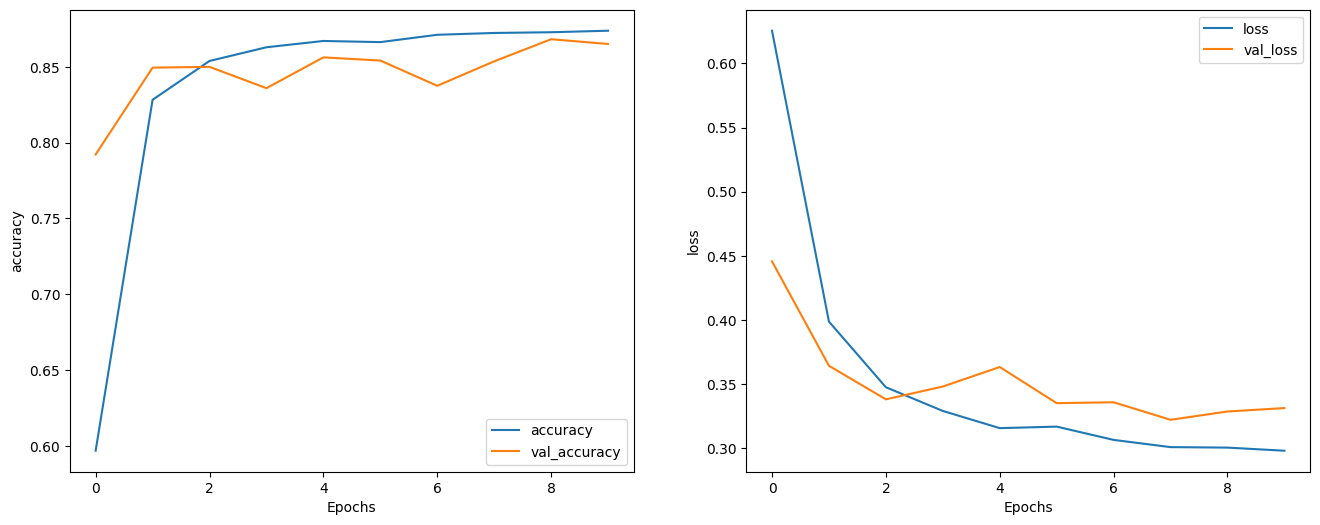

In [24]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')